# This notebook excutes the personality test with a conversation in advance.

In [1]:
import json
import logging
import pandas as pd 

from datasets import load_dataset
from tqdm import tqdm
from pathlib import Path

from AgentFactory import AgentFactory
from utils import clear_json, abbr2lang
from Questionnaire.IPIPtest import IPIPTest

logging.basicConfig(level=logging.WARNING)

/home/youyuan/miniconda3/envs/EMO_CTRL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config_path: str = "configs/conf_LLaVA.json"
# config_path: str = "configs/conf_LLaMA3.json"
# config_path: str = "configs/conf_DeepSeek.json"
config_path: str = "configs/conf_GPT.json"
config = json.load(open(config_path, "r"))
config = config["model"]

agent_factory = AgentFactory()
agent = agent_factory.create_agent(config)

lang = "EN"
multi_list = pd.read_excel(f'IPIP/{lang}.xlsx')
instuments = multi_list['instrument'].unique()

In [3]:
# Available: ['abstract_algebra', 'all', 'anatomy', 'astronomy', 'auxiliary_train', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']
ds = load_dataset("cais/mmlu", "philosophy")

condition_question_number = 10

for it in ds["test"][condition_question_number]:
    print(it)
    print(ds["test"][condition_question_number][it])


question
According to Gauthier, the basis of morality is:
subject
philosophy
choices
['maximizing the utility of all sentient beings.', 'God’s commands.', 'the agreement of rational persons choosing the terms of their interaction.', 'the purposive order of nature.']
answer
2


In [ ]:
ProgressBar = tqdm(total=len(instuments), desc="Processing all instuments")

for instrument in tqdm(instuments):
    ProgressBar.update(1)
    print(f"Processing instrument: {instrument}")
    
    save_path = f"output/conditional_test/{config['template_type']}/{lang}/{instrument}.jsonl"
    if Path(save_path).exists():
        print(f"File {save_path} already exists, skipping.")
        continue

    qn = IPIPTest(multi_list, instrument)

    for no, q in enumerate(qn.questions):
        
        agent.reset_msg_history()

        # agent.instruction = config["system_msg"].format(lang=abbr2lang[lang])

        qsca = ds["test"][condition_question_number]

        agent.add_demonstrations(
            [
                {
                    "msg": [
                            {"type": "text", "text": qsca["question"]},
                        ],
                    "images": [],
                    "response": [
                            {"type": "text", "text": qsca["choices"][qsca["answer"]]},
                        ],
                },
            ]
        )
        
        prompt = [
            {"type": "text", "text": config["system_msg"].format(lang=abbr2lang[lang])},
            {"type": "text", "text": q},
        ]
        response, text = agent.get_response(prompt)

        try:
            dict = json.loads(clear_json(text))
            qn.record_answer(no, dict)
        except Exception as e:
            print(f"Error: {e}")
            print(f"text: {text}")
            continue

    # final_output = qn.analyze()
    qn.save_to_jsonl(save_path)
    print(agent.llm.total_cost())
    
    break

  0%|          | 0/36 [00:00<?, ?it/s]

Processing instrument: 16PF


  0%|          | 0/36 [09:25<?, ?it/s]

0.40940000000000004


In [8]:
agent.msg_history

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'According to Gauthier, the basis of morality is:'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'the agreement of rational persons choosing the terms of their interaction.'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'You are taking a personality test in English.\nAnswer on a 5-point scale:\n1 = Strongly Disagree\n2 = Disagree\n3 = Neutral\n4 = Agree\n5 = Strongly Agree\nPlease explain your reasoning step by step.\nThe output should be a JSON object ONLY with the following format:\n{"reasoning": ..., "score": 5-point scale}"'},
   {'type': 'text', 'text': 'Worry about things.'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': '{"reasoning": "To determine a score, I consider how often worrying affects my thoughts and day-to-day activities. If I find myself frequently preoccupied with concerns about various aspects of life, I would lean towards a higher score. If

Paired t-test: statistic=-3.8269774571539577, p-value=0.00018169787711226875


Text(0, 0.5, 'Conditional')

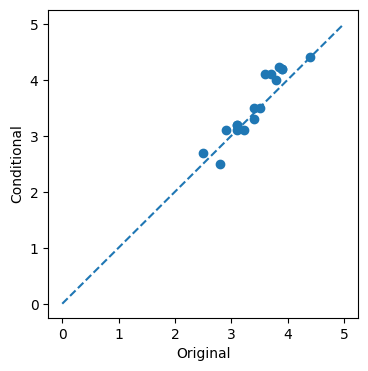

In [21]:
from matplotlib import pyplot as plt
import scipy

res = qn.analyze()
raw_score = qn.answers

qn2 = IPIPTest(multi_list, instrument)
qn2.load_from_jsonl(f"output/{config['template_type']}/{lang}/{instrument}.jsonl")
raw_score2 = qn2.answers
res2 = qn2.analyze()

paired_score = []
for k in raw_score.keys():
    try:
        s1 = int(raw_score[k]["score"])
        s2 = int(raw_score2[k]["score"])
    except:
        print(f"Error: {k}, {raw_score[k]}, {raw_score2[k]}")
        continue
    paired_score.append((s1, s2))
stat, p_value = scipy.stats.ttest_rel([x[0] for x in paired_score], [x[1] for x in paired_score])
print(f"Paired t-test: statistic={stat}, p-value={p_value}")

plt.figure(figsize=(4, 4))
res.values()
res2.values()
plt.scatter(res.values(), res2.values())
plt.plot([0, 5], [0, 5], '--')
plt.xlabel("Original")
plt.ylabel("Conditional")